## 기본설정 및 함수정의

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
from keplergl import KeplerGl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# tqdm의 pandas전용 메소드를 호출
tqdm.pandas()
# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)
 
# Point를만드는 함수
def make_point(x):
    try:
        return Point(x)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])
    
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.progress_apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

##### 행정동

In [3]:
# 하남시 행정동 데이터
shapefile_path1 = "SBJ_2411_001/bnd_dong_31180_2023_2Q/bnd_dong_31180_2023_2Q.shp"
hanam_gdf = gpd.read_file(shapefile_path1)
hanam_gdf = hanam_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 화성시 행정동 데이터
shapefile_path2 = "SBJ_2411_001/bnd_dong_31240_2023_2Q/bnd_dong_31240_2023_2Q.shp"
hwasung_gdf = gpd.read_file(shapefile_path2)
hwasung_gdf = hwasung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

#### 격자(매핑용)

In [58]:
# GeoJSON 파일 불러오기
with open('SBJ_2411_001/1-14.화성시_격자.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df_hwasung = pd.json_normalize(geojson_data['features'])
grid_map_df_hwasung['geometry'] = grid_map_df_hwasung['geometry.coordinates'].apply(lambda x : make_pol(x))
grid_map_df_hwasung.drop(columns="geometry.coordinates", axis=1, inplace=True)
grid_map_df_hwasung = grid_map_df_hwasung[~grid_map_df_hwasung['properties.gid'].str.startswith('다아')]
# grid_map_df_hwasung 데이터프레임을 GeoDataFrame으로 변환
grid_map_df_hwasung = gpd.GeoDataFrame(grid_map_df_hwasung, geometry='geometry')
grid_dict_hwasung = dict(zip(grid_map_df_hwasung['properties.gid'], grid_map_df_hwasung['geometry']))

In [60]:
# GeoJSON 파일 불러오기
with open('SBJ_2411_001/2-14.하남시_격자.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df_hanam = pd.json_normalize(geojson_data['features'])
grid_map_df_hanam['geometry'] = grid_map_df_hanam['geometry.coordinates'].apply(lambda x : make_pol(x))
grid_map_df_hanam.drop(columns="geometry.coordinates", axis=1, inplace=True)
grid_map_df_hanam = grid_map_df_hanam[~grid_map_df_hanam['properties.gid'].str.startswith('다아')]
# grid_map_df_hanam 데이터프레임을 GeoDataFrame으로 변환
grid_map_df_hanam = gpd.GeoDataFrame(grid_map_df_hanam, geometry='geometry')
grid_dict_hanam = dict(zip(grid_map_df_hanam['properties.gid'], grid_map_df_hanam['geometry']))

#### 공유차량 이용현황(화성)

In [84]:
sharecar_df = pd.read_csv('SBJ_2411_001/1-11.화성시_공유차량_이용현황.csv')
cols_to_exclude = ['car_type', 'car_cnt', 'car_type']  # 제외할 열
columns_to_fill = [col for col in sharecar_df.columns if col not in cols_to_exclude]
sharecar_df[columns_to_fill] = sharecar_df[columns_to_fill].fillna(0)
sharecar_df['car_type'] = sharecar_df['car_type'].fillna("")

from sklearn.linear_model import LinearRegression

train_data = sharecar_df.dropna(subset=['car_cnt', 'total_cnt', 'total_tm'])  # 세 열 모두 값이 있는 데이터
test_data = sharecar_df[sharecar_df['car_cnt'].isna()]  # car_cnt가 결측인 데이터

X_train = train_data[['total_cnt', 'total_tm']]  # 독립 변수
y_train = train_data['car_cnt']  # 종속 변수

model = LinearRegression()
model.fit(X_train, y_train)

if not test_data.empty:
    X_test = test_data[['total_cnt', 'total_tm']]
    predicted_car_cnt = model.predict(X_test) 
    predicted_car_cnt = np.maximum(predicted_car_cnt, 1)
    sharecar_df.loc[test_data.index, 'car_cnt'] = predicted_car_cnt.astype(int)

for col in columns_to_fill:
    if sharecar_df[col].dtype in ['float64', 'int64']:
        sharecar_df[col] = sharecar_df[col].astype(int)
sharecar_df["car_cnt"] = sharecar_df["car_cnt"].astype(int)


last_two_cols = sharecar_df.columns[-2:].tolist()
new_columns = list(sharecar_df.columns)
new_columns = [col for col in new_columns if col not in last_two_cols] 
new_columns[2:2] = last_two_cols 
sharecar_df = sharecar_df[new_columns]

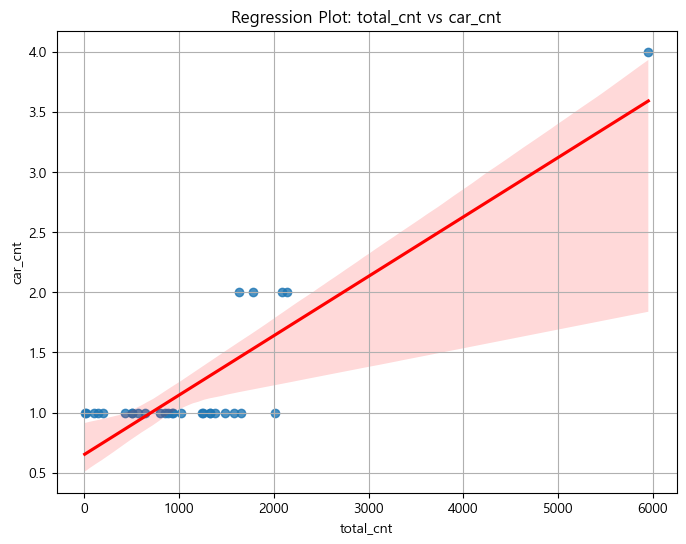

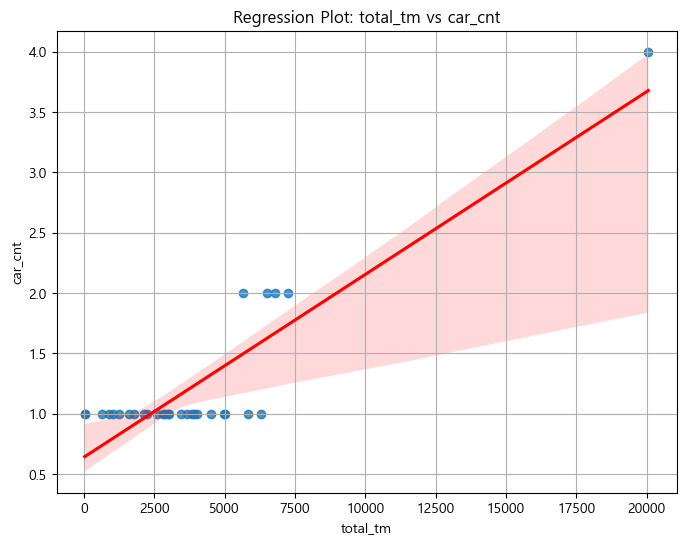

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

train_data = sharecar_df.dropna(subset=['car_cnt', 'total_cnt', 'total_tm'])

# 선형 회귀선 표시 (선형 관계 확인)
# (1) total_cnt와 car_cnt
plt.figure(figsize=(8, 6))
sns.regplot(x=train_data['total_cnt'], y=train_data['car_cnt'], line_kws={"color": "red"})
plt.title('Regression Plot: total_cnt vs car_cnt')
plt.xlabel('total_cnt')
plt.ylabel('car_cnt')
plt.grid()
plt.show()

# (2) total_tm와 car_cnt
plt.figure(figsize=(8, 6))
sns.regplot(x=train_data['total_tm'], y=train_data['car_cnt'], line_kws={"color": "red"})
plt.title('Regression Plot: total_tm vs car_cnt')
plt.xlabel('total_tm')
plt.ylabel('car_cnt')
plt.grid()
plt.show()


#### 공공주택 데이터 활용 매핑

In [86]:
sharehouse_df = pd.read_csv('SBJ_2411_001/1-12.공공주택임대_정보(화성시).csv')

# 그룹화 및 처리 함수 정의
def process_matching_rows(group):
    # 첫 번째와 두 번째 열: 같은 값이므로 하나의 값 선택
    col1_value = group.iloc[0, 0]  # 첫 번째 열
    col2_value = group.iloc[0, 1]  # 두 번째 열

    # 세 번째 열: ','로 구분해 값 결합
    col3_combined = ",".join(group.iloc[:, 2].astype(str).unique())  # 세 번째 열

    # 네 번째와 다섯 번째 열: 숫자 합산
    col4_sum = group.iloc[:, 3].sum()  # 네 번째 열
    col5_sum = group.iloc[:, 4].sum()  # 다섯 번째 열

    # 여섯 번째와 일곱 번째 열: 같은 값이므로 하나의 값 선택
    col6_value = group.iloc[0, 5]  # 여섯 번째 열
    col7_value = group.iloc[0, 6]  # 일곱 번째 열

    return pd.Series([col1_value, col2_value, col3_combined, col4_sum, col5_sum, col6_value, col7_value])

# sharehouse_df를 blck_cd 기준으로 그룹화하고 처리
processed_sharehouse = (
    sharehouse_df.groupby("blck_cd").apply(process_matching_rows)
)

# 열 이름 재설정
processed_sharehouse.columns = [
    "col1_value", "col2_value", "col3_combined", "col4_sum", "col5_sum", "col6_value", "col7_value"
]

# sharecar_df와 병합
merged_df = pd.merge(sharecar_df, processed_sharehouse, on="blck_cd", how="left")
merged_df = merged_df.iloc[:,2:]
new_column_names = sharehouse_df.columns
merged_df.columns = list(merged_df.columns[:-7]) + list(new_column_names)
merged_df = geo_transform(merged_df)
last_8_columns = merged_df.columns[-8:]
remaining_columns = merged_df.columns[:-8]
merged_df = merged_df[list(last_8_columns) + list(remaining_columns)]
merged_df['parking_slot'] = merged_df['parking_slot'].astype(int)
merged_df = merged_df.drop(columns=['lon', 'lat'])
merged_gdf = merged_df.reset_index(drop=True)
grid_map_gdf_hwasung = grid_map_df_hwasung.reset_index(drop=True)
joined_gdf = gpd.sjoin(merged_df, grid_map_gdf_hwasung, how='left', op='within')
joined_gdf['geometry'] = joined_gdf['properties.gid'].map(grid_dict_hwasung)
target_column = joined_gdf.columns[-2]
columns = list(joined_gdf.columns)
columns.remove(target_column)
columns.insert(5, target_column)
joined_gdf = joined_gdf[columns]
joined_gdf = joined_gdf.iloc[:,:-3]
joined_gdf['type_left'] = joined_gdf['type_left'].apply(lambda x : '+'.join(x.split(',')))
joined_gdf.rename(columns={'type_left':'type'}, inplace=True)
joined_gdf['type'] = joined_gdf['type'].apply(
    lambda x: '+'.join(sorted(x.split('+'))) if '+' in x else x
)

# 차량 활용 점수 (Vehicle Utilization Score, VUS) 계산코드드
joined_gdf['car_cnt'] = joined_gdf['car_cnt'].fillna(0).replace(0, 1)  # 0으로 나눔 방지
joined_gdf['total_cnt'] = joined_gdf['total_cnt'].fillna(0)
joined_gdf['total_tm'] = joined_gdf['total_tm'].fillna(0)

# 가중치 설정
w1, w2 = 0.5, 0.5  # 기본값: 건수와 시간을 동일한 비중으로 고려

# 차량 활용 점수 계산
joined_gdf['vehicle_utilization_score'] = (
    w1 * (joined_gdf['total_cnt'] / joined_gdf['car_cnt']) + 
    w2 * (joined_gdf['total_tm'] / joined_gdf['car_cnt'])
)

100%|██████████| 30/30 [00:00<00:00, 7441.99it/s]
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\user\AppData\Local\Temp\ipykerne

<Figure size 1200x600 with 0 Axes>

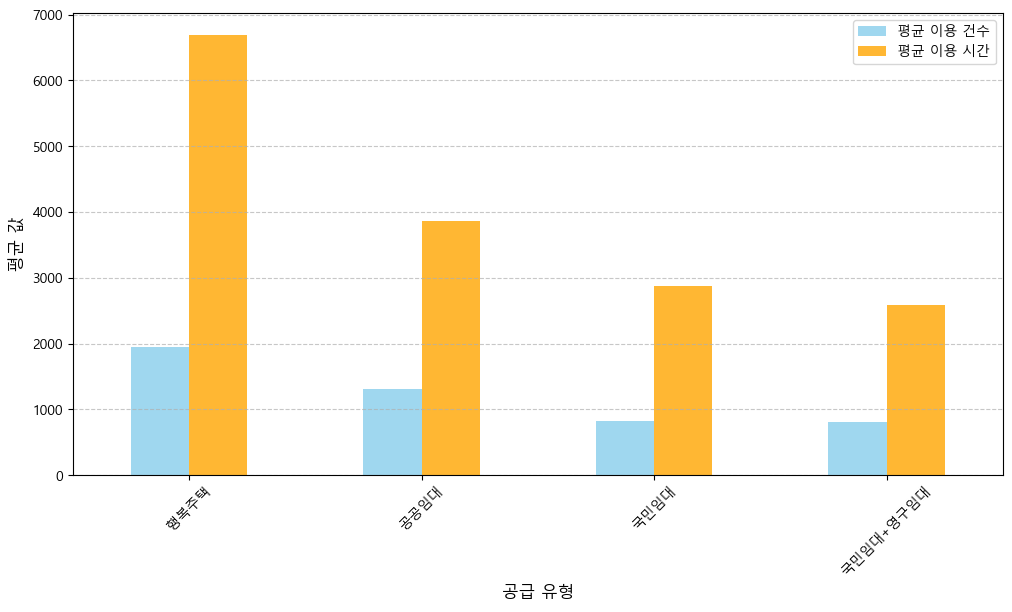

In [87]:
# 공급 유형별 평균 이용 건수와 이용 시간 계산
type_avg_usage = joined_gdf.groupby('type')[['total_cnt', 'total_tm']].mean().sort_values(by='total_cnt', ascending=False)

# 시각화: 평균 이용 건수와 평균 이용 시간 비교
plt.figure(figsize=(12, 6))
type_avg_usage.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'orange'], alpha=0.8)
plt.xlabel('공급 유형', fontsize=12)
plt.ylabel('평균 값', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['평균 이용 건수', '평균 이용 시간'])
plt.show()

# 공급 유형별 세대수(noh)와 배치 차량수(car_cnt)와의 비교
type_relative_usage = joined_gdf.groupby('type').agg({
    'noh': 'sum',
    'car_cnt': 'sum',
    'total_cnt': 'sum'
})
type_relative_usage['utilization_per_household'] = type_relative_usage['total_cnt'] / type_relative_usage['noh']  # 세대당 이용률
type_relative_usage['utilization_per_vehicle'] = type_relative_usage['total_cnt'] / type_relative_usage['car_cnt']  # 차량당 이용률

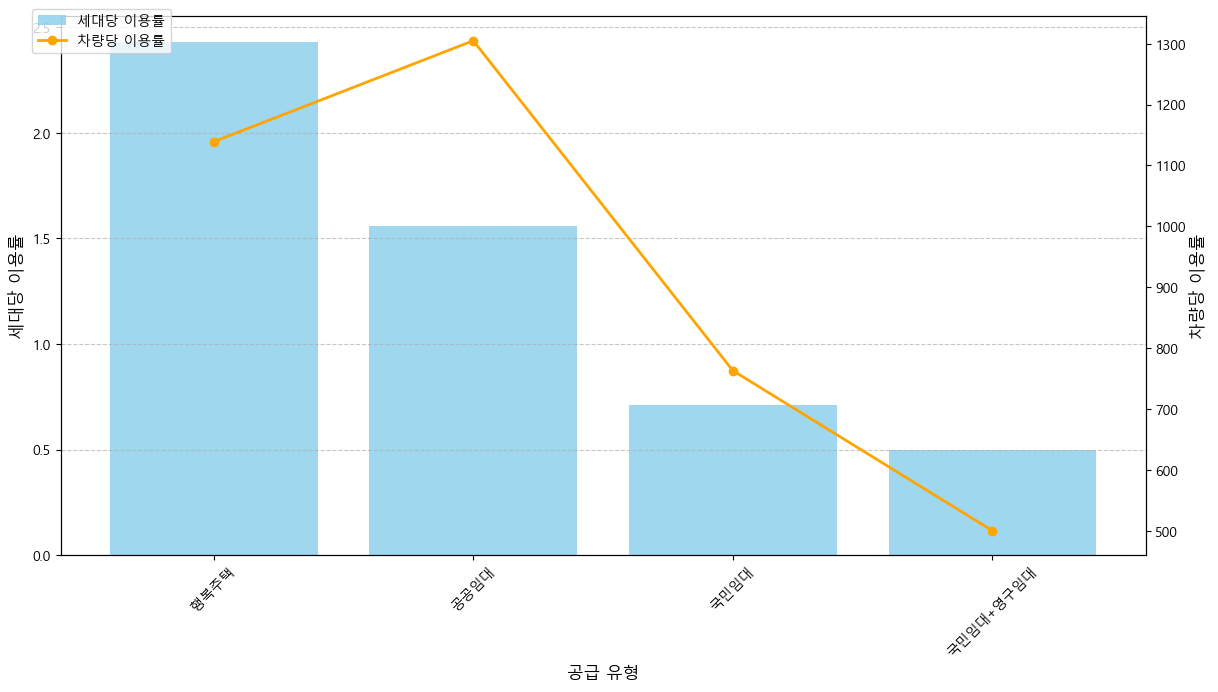

In [67]:
data = {
    'type': ['행복주택', '공공임대', '국민임대', '국민임대+영구임대'],
    'utilization_per_household': [2.43, 1.56, 0.71, 0.5],
    'utilization_per_vehicle': [1139, 1305, 763, 500]
}
type_relative_usage = pd.DataFrame(data).set_index('type')

# Supply type-wise utilization visualization with corrected bar chart
fig, ax1 = plt.subplots(figsize=(14, 7))

# Household utilization rate - bar chart
ax1.bar(type_relative_usage.index, type_relative_usage['utilization_per_household'], color='skyblue', alpha=0.8, label='세대당 이용률')
ax1.set_xlabel('공급 유형', fontsize=12)
ax1.set_ylabel('세대당 이용률', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Vehicle utilization rate - line chart (secondary axis)
ax2 = ax1.twinx()
ax2.plot(type_relative_usage.index, type_relative_usage['utilization_per_vehicle'], color='orange', marker='o', label='차량당 이용률', linewidth=2)
ax2.set_ylabel('차량당 이용률', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adding legend
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()


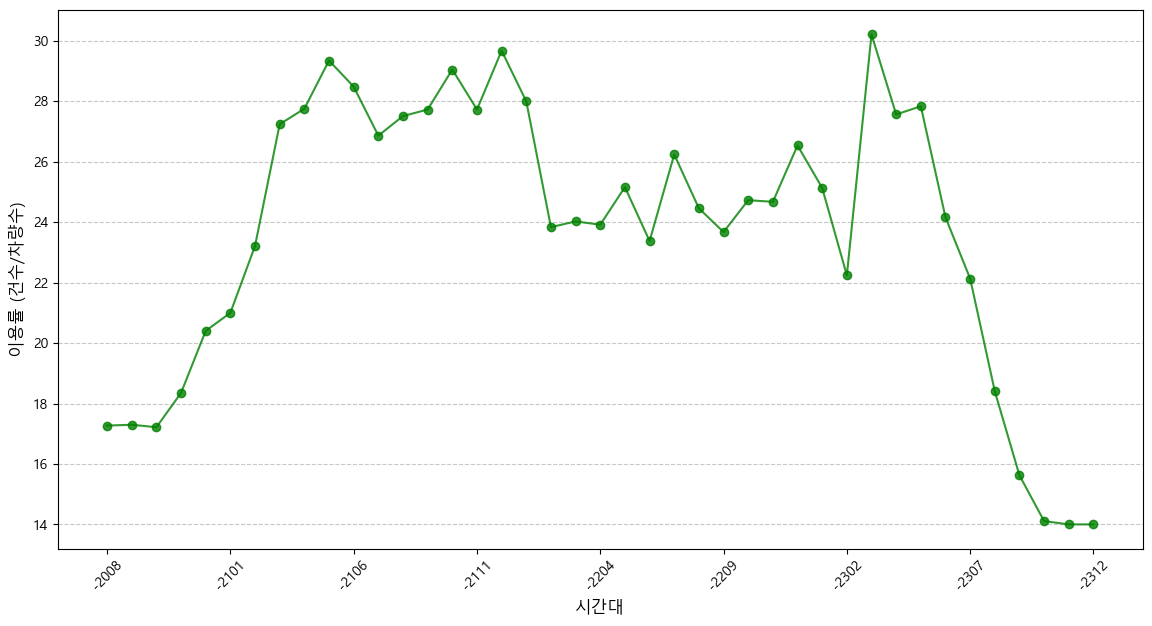

-2008    17.270270
-2009    17.297297
-2010    17.216216
-2011    18.351351
-2012    20.405405
-2101    21.000000
-2102    23.216216
-2103    27.243243
-2104    27.756757
-2105    29.351351
-2106    28.486486
-2107    26.864865
-2108    27.513514
-2109    27.729730
-2110    29.054054
-2111    27.729730
-2112    29.675676
-2201    28.000000
-2202    23.837838
-2203    24.027027
-2204    23.918919
-2205    25.162162
-2206    23.378378
-2207    26.243243
-2208    24.459459
-2209    23.675676
-2210    24.729730
-2211    24.675676
-2212    26.540541
-2301    25.135135
-2302    22.243243
-2303    30.216216
-2304    27.567568
-2305    27.837838
-2306    24.162162
-2307    22.135135
-2308    18.405405
-2309    15.621622
-2310    14.108108
-2311    14.000000
-2312    14.000000
dtype: float64

In [68]:
# 'cnt_****' 컬럼 추출
time_columns = [col for col in joined_gdf.columns if col.startswith('cnt_')]

# 차량 수 합계 계산
total_car_count = joined_gdf['car_cnt'].sum()

# 시간대별 이용 건수 합계 계산
time_usage = joined_gdf[time_columns].sum()

# 시간대별 이용률 계산
time_usage_rate = time_usage / total_car_count

# 시간대 포맷 변경 (ex: 'cnt_2008' -> '2020-08')
time_usage_rate.index = [f"{col[4:]}-{col[:4]}" for col in time_usage_rate.index.str.replace('cnt_', '')]

# 시계열 데이터 정렬
time_usage_rate = time_usage_rate.sort_index()

# 시각화: 시간대별 이용률
plt.figure(figsize=(14, 7))
time_usage_rate.plot(color='green', marker='o', linestyle='-', alpha=0.8)
plt.xlabel('시간대', fontsize=12)
plt.ylabel('이용률 (건수/차량수)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

time_usage_rate

In [ ]:
# 맵 객체 생성 및 데이터 로드
hwasung_share_map = KeplerGl(height=1000, width=1500)
hwasung_share_map.add_data(data=joined_gdf, name="공유차량 병합 데이터")
hwasung_share_map.add_data(data=hwasung_gdf, name="화성시 행정동 데이터")

hwasung_share_map

In [ ]:
# 맵 저장
hwasung_share_map.save_to_html(file_name="visualization/화성시 현황/화성시 공유차량 시각화 map.html")

#### 공유차량 이용현황(하남)

In [76]:
sharecar_df = pd.read_csv('SBJ_2411_001/2-11.하남시_공유차량_이용현황.csv')
cols_to_exclude = ['car_type', 'car_cnt', 'car_type']  # 제외할 열
columns_to_fill = [col for col in sharecar_df.columns if col not in cols_to_exclude]
sharecar_df[columns_to_fill] = sharecar_df[columns_to_fill].fillna(0)
sharecar_df['car_type'] = sharecar_df['car_type'].fillna("")

from sklearn.linear_model import LinearRegression

train_data = sharecar_df.dropna(subset=['car_cnt', 'total_cnt', 'total_tm'])  # 세 열 모두 값이 있는 데이터
test_data = sharecar_df[sharecar_df['car_cnt'].isna()]  # car_cnt가 결측인 데이터

X_train = train_data[['total_cnt', 'total_tm']]  # 독립 변수
y_train = train_data['car_cnt']  # 종속 변수

model = LinearRegression()
model.fit(X_train, y_train)

if not test_data.empty:
    X_test = test_data[['total_cnt', 'total_tm']]
    predicted_car_cnt = model.predict(X_test) 
    predicted_car_cnt = np.maximum(predicted_car_cnt, 1)
    sharecar_df.loc[test_data.index, 'car_cnt'] = predicted_car_cnt.astype(int)

for col in columns_to_fill:
    if sharecar_df[col].dtype in ['float64', 'int64']:
        sharecar_df[col] = sharecar_df[col].astype(int)
sharecar_df["car_cnt"] = sharecar_df["car_cnt"].astype(int)


last_two_cols = sharecar_df.columns[-2:].tolist()
new_columns = list(sharecar_df.columns)
new_columns = [col for col in new_columns if col not in last_two_cols] 
new_columns[2:2] = last_two_cols 
sharecar_df = sharecar_df[new_columns]

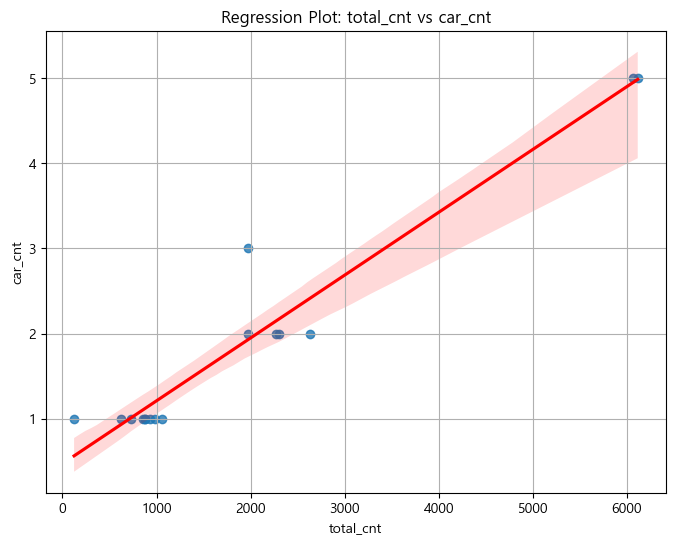

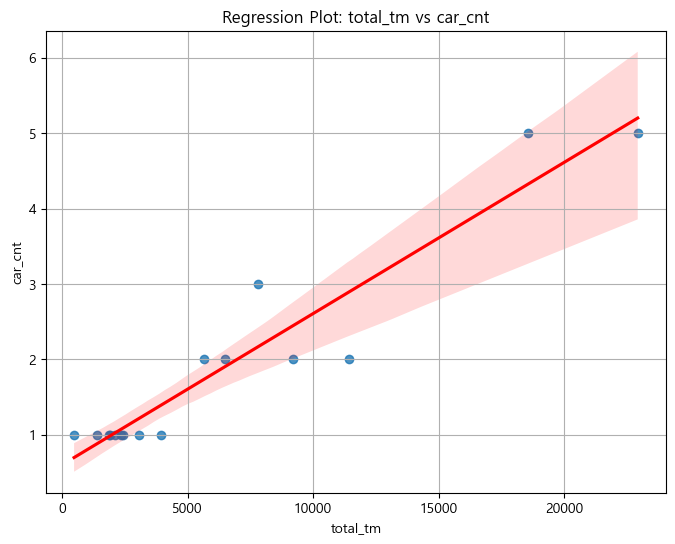

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

train_data = sharecar_df.dropna(subset=['car_cnt', 'total_cnt', 'total_tm'])

# 선형 회귀선 표시 (선형 관계 확인)
# (1) total_cnt와 car_cnt
plt.figure(figsize=(8, 6))
sns.regplot(x=train_data['total_cnt'], y=train_data['car_cnt'], line_kws={"color": "red"})
plt.title('Regression Plot: total_cnt vs car_cnt')
plt.xlabel('total_cnt')
plt.ylabel('car_cnt')
plt.grid()
plt.show()

# (2) total_tm와 car_cnt
plt.figure(figsize=(8, 6))
sns.regplot(x=train_data['total_tm'], y=train_data['car_cnt'], line_kws={"color": "red"})
plt.title('Regression Plot: total_tm vs car_cnt')
plt.xlabel('total_tm')
plt.ylabel('car_cnt')
plt.grid()
plt.show()


#### 공공주택 데이터 활용 매핑

In [78]:
sharehouse_df = pd.read_csv('SBJ_2411_001/2-12.공공주택임대_정보(하남시).csv')

# 그룹화 및 처리 함수 정의
def process_matching_rows(group):
    # 첫 번째와 두 번째 열: 같은 값이므로 하나의 값 선택
    col1_value = group.iloc[0, 0]  # 첫 번째 열
    col2_value = group.iloc[0, 1]  # 두 번째 열

    # 세 번째 열: ','로 구분해 값 결합
    col3_combined = ",".join(group.iloc[:, 2].astype(str).unique())  # 세 번째 열

    # 네 번째와 다섯 번째 열: 숫자 합산
    col4_sum = group.iloc[:, 3].sum()  # 네 번째 열
    col5_sum = group.iloc[:, 4].sum()  # 다섯 번째 열

    # 여섯 번째와 일곱 번째 열: 같은 값이므로 하나의 값 선택
    col6_value = group.iloc[0, 5]  # 여섯 번째 열
    col7_value = group.iloc[0, 6]  # 일곱 번째 열

    return pd.Series([col1_value, col2_value, col3_combined, col4_sum, col5_sum, col6_value, col7_value])

# sharehouse_df를 blck_cd 기준으로 그룹화하고 처리
processed_sharehouse = (
    sharehouse_df.groupby("blck_cd").apply(process_matching_rows)
)

# 열 이름 재설정
processed_sharehouse.columns = [
    "col1_value", "col2_value", "col3_combined", "col4_sum", "col5_sum", "col6_value", "col7_value"
]

# sharecar_df와 병합
merged_df = pd.merge(sharecar_df, processed_sharehouse, on="blck_cd", how="left")
merged_df = merged_df.iloc[:,2:]
new_column_names = sharehouse_df.columns
merged_df.columns = list(merged_df.columns[:-7]) + list(new_column_names)
merged_df = geo_transform(merged_df)
last_8_columns = merged_df.columns[-8:]
remaining_columns = merged_df.columns[:-8]

merged_df = merged_df[list(last_8_columns) + list(remaining_columns)]
merged_df['parking_slot'] = merged_df['parking_slot'].fillna(0)
merged_df['parking_slot'] = merged_df['parking_slot'].astype(int)
merged_df = merged_df.drop(columns=['lon', 'lat'])
merged_gdf = merged_df.reset_index(drop=True)

grid_map_gdf_hanam = grid_map_df_hanam.reset_index(drop=True)
joined_gdf = gpd.sjoin(merged_df, grid_map_gdf_hanam, how='left', op='within')
joined_gdf['geometry'] = joined_gdf['properties.gid'].map(grid_dict_hanam)
target_column = joined_gdf.columns[-2]
columns = list(joined_gdf.columns)
columns.remove(target_column)
columns.insert(5, target_column)

joined_gdf = joined_gdf[columns]
joined_gdf = joined_gdf.iloc[:,:-3]
joined_gdf = joined_gdf.dropna(subset=['blck_cd'])
joined_gdf['noh'] = joined_gdf['noh'].astype(int)
joined_gdf['type_left'] = joined_gdf['type_left'].apply(lambda x : '+'.join(x.split(',')))
joined_gdf.rename(columns={'type_left':'type'}, inplace=True)
joined_gdf['type'] = joined_gdf['type'].apply(
    lambda x: '+'.join(sorted(x.split('+'))) if '+' in x else x
)

# 차량 활용 점수 (Vehicle Utilization Score, VUS) 계산코드드
joined_gdf['car_cnt'] = joined_gdf['car_cnt'].fillna(0).replace(0, 1)  # 0으로 나눔 방지
joined_gdf['total_cnt'] = joined_gdf['total_cnt'].fillna(0)
joined_gdf['total_tm'] = joined_gdf['total_tm'].fillna(0)

# 가중치 설정
w1, w2 = 0.5, 0.5  # 기본값: 건수와 시간을 동일한 비중으로 고려

# 차량 활용 점수 계산
joined_gdf['vehicle_utilization_score'] = (
    w1 * (joined_gdf['total_cnt'] / joined_gdf['car_cnt']) + 
    w2 * (joined_gdf['total_tm'] / joined_gdf['car_cnt'])
)

100%|██████████| 16/16 [00:00<00:00, 7995.81it/s]


c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\user\AppData\Local\Temp\ipykernel_15184\3388987130.py:48: UserWarning:

CRS misma

<Figure size 1200x600 with 0 Axes>

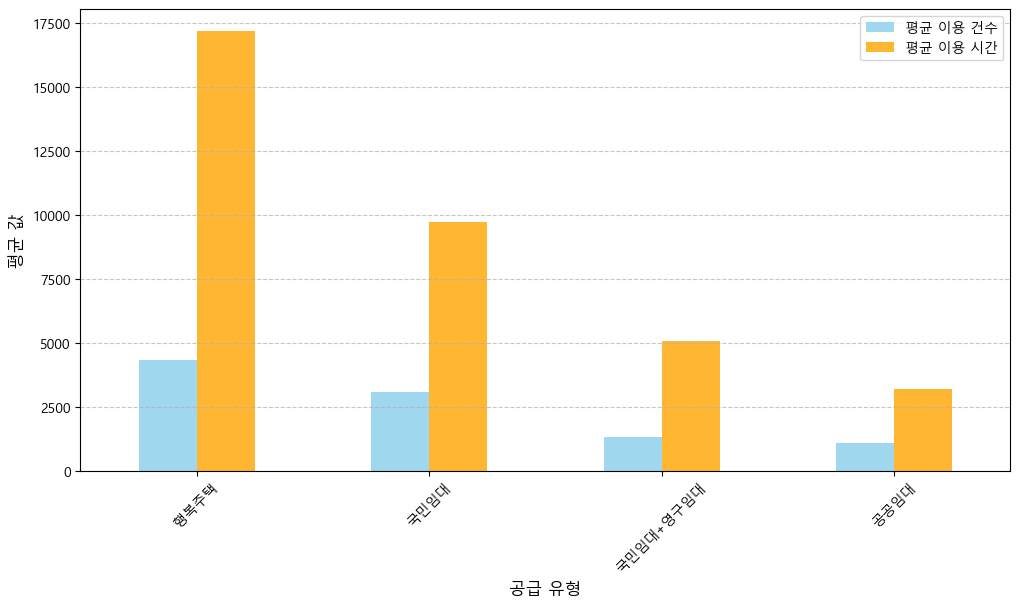

In [79]:
# 공급 유형별 평균 이용 건수와 이용 시간 계산
type_avg_usage = joined_gdf.groupby('type')[['total_cnt', 'total_tm']].mean().sort_values(by='total_cnt', ascending=False)

# 시각화: 평균 이용 건수와 평균 이용 시간 비교
plt.figure(figsize=(12, 6))
type_avg_usage.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'orange'], alpha=0.8)
plt.xlabel('공급 유형', fontsize=12)
plt.ylabel('평균 값', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['평균 이용 건수', '평균 이용 시간'])
plt.show()

# 공급 유형별 세대수(noh)와 배치 차량수(car_cnt)와의 비교
type_relative_usage = joined_gdf.groupby('type').agg({
    'noh': 'sum',
    'car_cnt': 'sum',
    'total_cnt': 'sum'
})
type_relative_usage['utilization_per_household'] = type_relative_usage['total_cnt'] / type_relative_usage['noh']  # 세대당 이용률
type_relative_usage['utilization_per_vehicle'] = type_relative_usage['total_cnt'] / type_relative_usage['car_cnt']  # 차량당 이용률

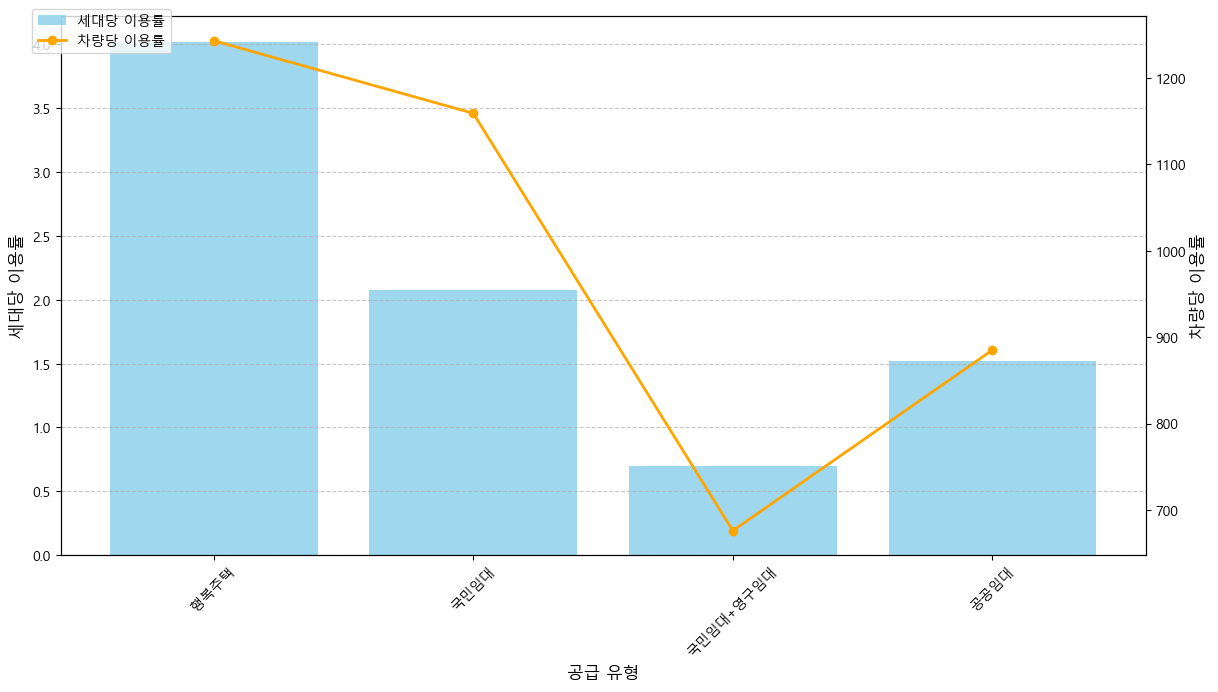

In [81]:
data = {
    'type': ['행복주택', '국민임대', '국민임대+영구임대', '공공임대'],
    'utilization_per_household': [4.02, 2.08, 0.70, 1.52],
    'utilization_per_vehicle': [1243, 1159, 676, 885]
}
type_relative_usage = pd.DataFrame(data).set_index('type')

# Supply type-wise utilization visualization with corrected bar chart
fig, ax1 = plt.subplots(figsize=(14, 7))

# Household utilization rate - bar chart
ax1.bar(type_relative_usage.index, type_relative_usage['utilization_per_household'], color='skyblue', alpha=0.8, label='세대당 이용률')
ax1.set_xlabel('공급 유형', fontsize=12)
ax1.set_ylabel('세대당 이용률', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Vehicle utilization rate - line chart (secondary axis)
ax2 = ax1.twinx()
ax2.plot(type_relative_usage.index, type_relative_usage['utilization_per_vehicle'], color='orange', marker='o', label='차량당 이용률', linewidth=2)
ax2.set_ylabel('차량당 이용률', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adding legend
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()


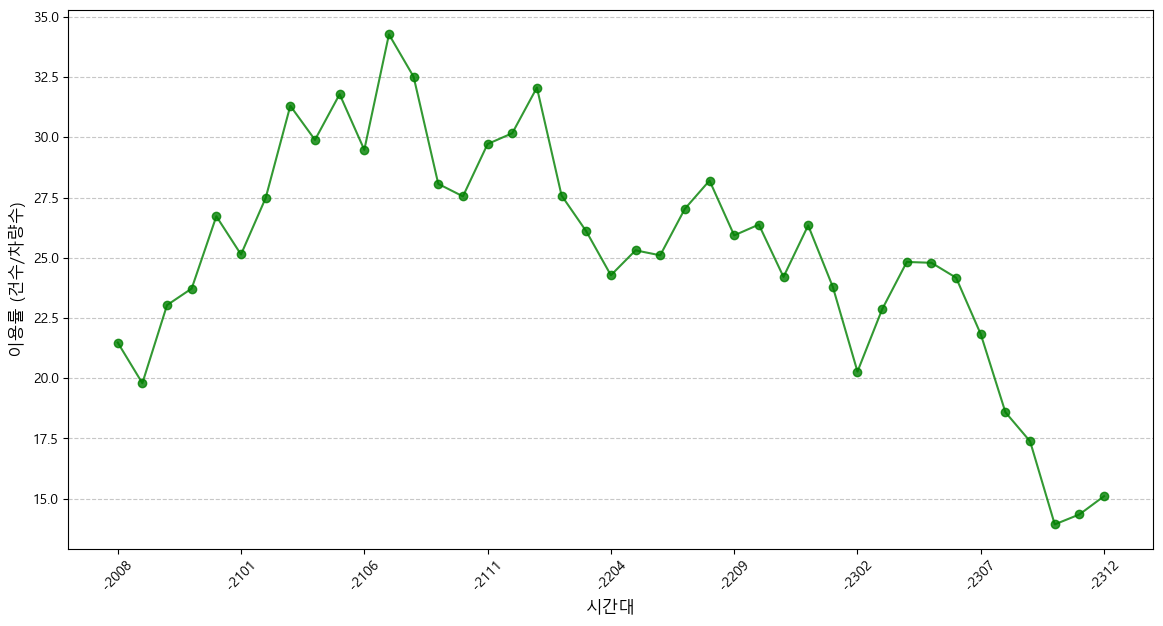

-2008    21.482759
-2009    19.793103
-2010    23.034483
-2011    23.724138
-2012    26.724138
-2101    25.137931
-2102    27.482759
-2103    31.310345
-2104    29.896552
-2105    31.793103
-2106    29.482759
-2107    34.275862
-2108    32.517241
-2109    28.068966
-2110    27.551724
-2111    29.724138
-2112    30.172414
-2201    32.068966
-2202    27.586207
-2203    26.103448
-2204    24.275862
-2205    25.310345
-2206    25.103448
-2207    27.034483
-2208    28.206897
-2209    25.931034
-2210    26.379310
-2211    24.206897
-2212    26.344828
-2301    23.793103
-2302    20.275862
-2303    22.862069
-2304    24.827586
-2305    24.793103
-2306    24.172414
-2307    21.827586
-2308    18.586207
-2309    17.379310
-2310    13.931034
-2311    14.344828
-2312    15.103448
dtype: float64

In [82]:
# 'cnt_****' 컬럼 추출
time_columns = [col for col in joined_gdf.columns if col.startswith('cnt_')]

# 차량 수 합계 계산
total_car_count = joined_gdf['car_cnt'].sum()

# 시간대별 이용 건수 합계 계산
time_usage = joined_gdf[time_columns].sum()

# 시간대별 이용률 계산
time_usage_rate = time_usage / total_car_count

# 시간대 포맷 변경 (ex: 'cnt_2008' -> '2020-08')
time_usage_rate.index = [f"{col[4:]}-{col[:4]}" for col in time_usage_rate.index.str.replace('cnt_', '')]

# 시계열 데이터 정렬
time_usage_rate = time_usage_rate.sort_index()

# 시각화: 시간대별 이용률
plt.figure(figsize=(14, 7))
time_usage_rate.plot(color='green', marker='o', linestyle='-', alpha=0.8)
plt.xlabel('시간대', fontsize=12)
plt.ylabel('이용률 (건수/차량수)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

time_usage_rate

In [ ]:
# 맵 객체 생성 및 데이터 로드
hanam_share_map = KeplerGl(height=1000, width=1500)
hanam_share_map.add_data(data=joined_gdf, name="공유차량 병합 데이터")
hanam_share_map.add_data(data=hanam_gdf, name="하남시 행정동 데이터")

hanam_share_map

In [79]:
# 맵 저장
hanam_share_map.save_to_html(file_name="visualization/하남시 현황/하남시 공유차량 시각화 map.html")

Map saved to visualization/하남시 현황/하남시 공유차량 시각화 map.html!


#### 예측모델 학습

In [124]:
property1_df = pd.read_csv('property1_df.csv')
property2_df = pd.read_csv('property2_df.csv')
property3_df = pd.read_csv('property3_df.csv')


# Select the common columns
common_columns = ['blck_cd', 'type', 'noh', 'total_cnt', 'total_tm', 'car_cnt', 'vehicle_utilization_score']
property_df1 = pd.merge(property1_df, property2_df, on=common_columns, how='outer', suffixes=('', '_prop1'))
property_df2 = pd.merge(property_df1, property3_df, on=common_columns, how='outer', suffixes=('', '_prop2'))

# Merge new hanam datasets
property1_hanam_df = pd.read_csv('property1_hanam_df.csv')
property2_hanam_df = pd.read_csv('property2_hanam_df.csv')
property3_hanam_df = pd.read_csv('property3_hanam_df.csv')
property_hanam_df1 = pd.merge(property1_hanam_df, property2_hanam_df, on=common_columns, how='outer', suffixes=('', '_prop1'))
property_hanam_df2 = pd.merge(property_hanam_df1, property3_hanam_df, on=common_columns, how='outer', suffixes=('', '_prop2'))

# 화성 & 하남 통합 property 데이터프레임
property_merge = pd.concat([property_df2, property_hanam_df2], ignore_index=True)

In [125]:
property_merge = property_merge.drop(columns=['vehicle_utilization_score', 'pay_rent'])

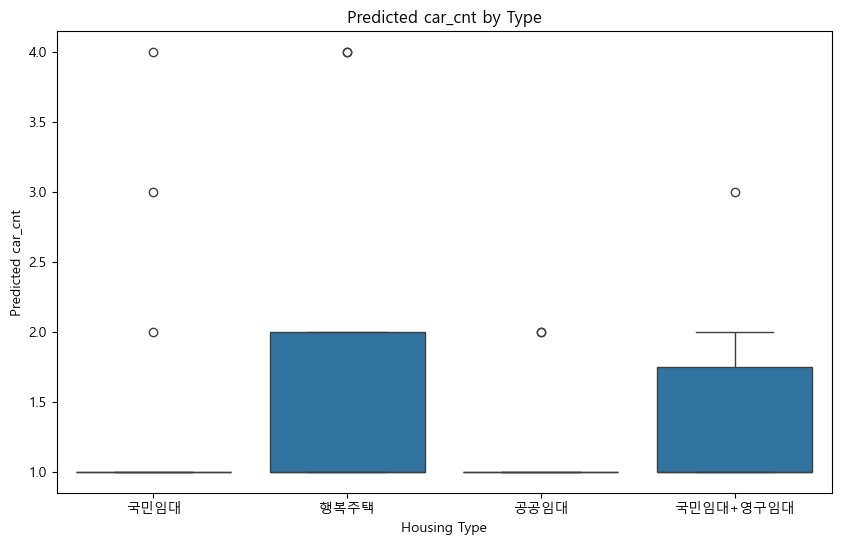

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# 문자열 -> 숫자 변환
if 'type' in property_merge.columns:
    property_merge['type_encoded'] = property_merge['type'].astype('category').cat.codes

# 'type' 열 변환 (str -> int)
type_mapping = {t: i + 1 for i, t in enumerate(property_merge['type'].unique())}
property_merge['type_encoded'] = property_merge['type'].map(type_mapping)
#property_merge = property_merge.drop(columns=['total_cnt', 'total_tm'])

# 학습 데이터(X)와 타겟 데이터(y) 분리
X = property_merge.drop(columns=['blck_cd', 'car_cnt', 'type'])  # 'car_cnt'는 타겟, 'type'은 원본 문자열 열 제거
y = property_merge['car_cnt']

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=400,  # 트리 개수를 증가
    learning_rate=0.01,  # 학습률 감소
    max_depth=15,  # 트리 깊이 증가
    min_child_weight=1.5,  # 최소 리프 노드 가중치
    subsample=0.8,  # 데이터 샘플링 비율
    colsample_bytree=0.8,  # 특성 샘플링 비율
    random_state=42
)


xgb_model.fit(X_train, y_train)

# 예측 (반올림 및 최솟값 적용)
y_pred = xgb_model.predict(X_test)
#y_pred = [max(1, round(val)) for val in y_pred]  # 반올림 및 최솟값 1 적용

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)  # R-squared

# 결과 정리
evaluation_results = pd.DataFrame({'Metric': ['MSE', 'MAE', 'R-squared'], 'Value': [mse, mae, r2]})

# 실제 값과 예측 값 비교
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# 전체 데이터에 대한 예측 (반올림 및 최솟값 적용)
property_merge['Predicted_car_cnt'] = xgb_model.predict(property_merge.drop(columns=['blck_cd', 'car_cnt', 'type']))
property_merge['Predicted_car_cnt'] = property_merge['Predicted_car_cnt'].apply(lambda x: max(1, round(x)))

# Type별 car_cnt 예측 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(data=property_merge, x='type', y='Predicted_car_cnt')
plt.title("Predicted car_cnt by Type")
plt.xlabel("Housing Type")
plt.ylabel("Predicted car_cnt")
plt.show()


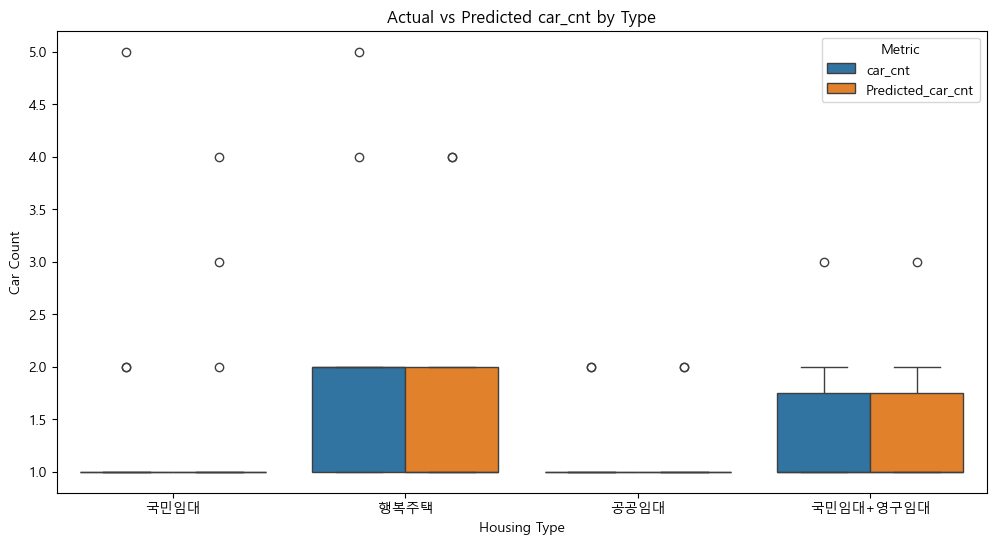

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# 실제값과 예측값 데이터를 합친 데이터프레임 준비
comparison_df = property_merge.copy()

# 데이터 재구조화: Metric 열 추가 (Actual과 Predicted 구분)
comparison_melted = comparison_df.melt(
    id_vars=['type'], 
    value_vars=['car_cnt', 'Predicted_car_cnt'], 
    var_name='Metric', 
    value_name='car_count'  # 기존 열 이름과 충돌하지 않도록 변경
)

# Box Plot 생성
plt.figure(figsize=(12, 6))
sns.boxplot(data=comparison_melted, x='type', y='car_count', hue='Metric')
plt.title("Actual vs Predicted car_cnt by Type")
plt.xlabel("Housing Type")
plt.ylabel("Car Count")
plt.legend(title="Metric", loc="upper right")
plt.show()


In [128]:
evaluation_results


,Metric,Value
0,MSE,0.265477
1,MAE,0.355129
2,R-squared,0.823741


In [132]:
comparison_df

,Actual,Predicted
39,1,1.059698
25,1,1.008688
26,1,1.007260
43,5,4.025777
35,2,1.912539
41,2,2.950610
4,2,1.087393
12,1,1.007128
8,1,1.011146


#### 대상구역

In [146]:
# GeoJSON 파일 불러오기
with open('SBJ_2411_001/3.대상구역도(하남교산).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
object_area_df = pd.json_normalize(geojson_data['features'])
object_area_df['geometry'] = object_area_df['geometry.coordinates'].apply(lambda x : make_pol(x))
object_area_df.drop(columns="geometry.coordinates", inplace=True)
object_area_df = gpd.GeoDataFrame(object_area_df, geometry='geometry')
sharehouse_object = object_area_df[object_area_df['properties.blockType'] == "공동주택"]
sharehouse_object = sharehouse_object[['properties.blockName', 'geometry']]
sh_sup = pd.read_csv('SBJ_2411_001/Housing_Supply_Data.csv')
sh_ob_sup = pd.merge(sh_sup, sharehouse_object, left_on='획지번호', right_on='properties.blockName', how='left')
sh_ob_sup.drop(columns=['properties.blockName'], inplace=True)
sh_ob_sup.columns = ['blockname', 'noh', 'pop', 'type', 'geometry']
sh_ob_sup.drop(columns=['pop'], inplace=True)
sh_ob_sup = gpd.GeoDataFrame(sh_ob_sup, geometry='geometry')

In [ ]:
# 맵 객체 생성 및 데이터 로드
hanam = KeplerGl(height=1000, width=1500)
hanam.add_data(data=object_area_df, name="대상지구 데이터")

hanam

In [150]:
sh_ob_sup.to_csv('sh_ob_sup.csv', index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 예시 데이터프레임 생성 (sh_ob_sup 데이터프레임이 준비되어 있다고 가정)
# sh_ob_sup = pd.read_csv('your_data.csv')  # 데이터를 불러오는 경우

# 1. 'type' 열의 값 분포 확인
type_distribution = sh_ob_sup['type'].value_counts()
print("Value counts for 'type':")
print(type_distribution)

# 2. 'type' 열의 값 비율 확인
type_distribution_ratio = sh_ob_sup['type'].value_counts(normalize=True) * 100
print("\nPercentage distribution for 'type':")
print(type_distribution_ratio)

# 3. 분포 시각화: 막대그래프
plt.figure(figsize=(8, 6))
type_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of 'type'", fontsize=16)
plt.xlabel("Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

# 4. 분포 시각화: 파이차트
plt.figure(figsize=(8, 8))
type_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title("Percentage Distribution of 'type'", fontsize=16)
plt.ylabel("")  # Y축 라벨 제거
plt.show()


In [154]:
property1_new_df = pd.read_csv('property1_new_df.csv')
property2_new_df = pd.read_csv('property2_new_df.csv')
property3_new_df = pd.read_csv('property3_new_df.csv')

# Select the common columns
common_columns = ['blockname', 'type', 'noh']
property_new_df = pd.merge(property1_new_df, property2_new_df, on=common_columns, how='outer', suffixes=('', '_prop1'))
property_new_df = pd.merge(property_new_df, property3_new_df, on=common_columns, how='outer', suffixes=('', '_prop2'))

In [155]:
property_new_df

,blockname,type,noh,거주인구_20대_여,거주인구_20대_남,거주인구_30대_여,거주인구_30대_남,거주인구_40대_여,거주인구_40대_남,거주인구_50대_여,거주인구_50대_남,거주인구_60대_여,거주인구_60대_남,거주인구_70대_여,거주인구_70대_남,거주인구_80대_여,거주인구_80대_남,거주인구_90대_여,거주인구_90대_남,거주인구_100대_여,거주인구_100대_남,유동인구_10대_여,유동인구_10대_남,유동인구_20대_여,유동인구_20대_남,유동인구_30대_여,유동인구_30대_남,유동인구_40대_여,유동인구_40대_남,유동인구_50대_여,유동인구_50대_남,유동인구_60대_여,유동인구_60대_남,business_count_within_5000m,nearest_bus_distance,nearest_subway_distance,congestion
0,A-1,통합공공임대,823,679.25,658.00,886.00,864.00,966.50,949.00,900.75,1031.75,1006.00,1153.75,561.50,617.00,171.25,292.25,3.5,10.75,0.0,0.0,932.85,982.05,1665.06,1413.33,3319.16,2291.88,5100.99,3439.99,5756.01,3651.00,7519.15,4900.65,60,104.056917,407.921645,2.025988
1,A-1,통합공공임대,823,679.25,658.00,886.00,864.00,966.50,949.00,900.75,1031.75,1006.00,1153.75,561.50,617.00,171.25,292.25,3.5,10.75,0.0,0.0,932.85,982.05,1665.06,1413.33,3319.16,2291.88,5100.99,3439.99,5756.01,3651.00,7519.15,4900.65,60,104.056917,407.921645,2.025988
2,A-1,통합공공임대,823,679.25,658.00,886.00,864.00,966.50,949.00,900.75,1031.75,1006.00,1153.75,561.50,617.00,171.25,292.25,3.5,10.75,0.0,0.0,932.85,982.05,1665.06,1413.33,3319.16,2291.88,5100.99,3439.99,5756.01,3651.00,7519.15,4900.65,60,104.056917,407.921645,2.025988
3,A-1,통합공공임대,823,679.25,658.00,886.00,864.00,966.50,949.00,900.75,1031.75,1006.00,1153.75,561.50,617.00,171.25,292.25,3.5,10.75,0.0,0.0,932.85,982.05,1665.06,1413.33,3319.16,2291.88,5100.99,3439.99,5756.01,3651.00,7519.15,4900.65,60,104.056917,407.921645,2.025988
4,A-1,통합공공임대,823,679.25,658.00,886.00,864.00,966.50,949.00,900.75,1031.75,1006.00,1153.75,561.50,617.00,171.25,292.25,3.5,10.75,0.0,0.0,932.85,982.05,1665.06,1413.33,3319.16,2291.88,5100.99,3439.99,5756.01,3651.00,7519.15,4900.65,60,104.056917,407.921645,2.025988
5,A-1,통합공공임대,823,679.25,658.00,886.00,864.00,966.50,949.00,900.75,1031.75,1006.00,1153.75,561.50,617.00,171.25,292.25,3.5,10.75,0.0,0.0,932.85,982.05,1665.06,1413.33,3319.16,2291.88,5100.99,3439.99,5756.01,3651.00,7519.15,4900.65,60,104.056917,407.921645,2.025988
6,A-1,통합공공임대,823,679.25,658.00,886.00,864.00,966.50,949.00,900.75,1031.75,1006.00,1153.75,561.50,617.00,171.25,292.25,3.5,10.75,0.0,0.0,932.85,982.05,1665.06,1413.33,3319.16,2291.88,5100.99,3439.99,5756.01,3651.00,7519.15,4900.65,60,104.056917,407.921645,2.025988
7,A-1,통합공공임대,823,679.25,658.00,886.00,864.00,966.50,949.00,900.75,1031.75,1006.00,1153.75,561.50,617.00,171.25,292.25,3.5,10.75,0.0,0.0,932.85,982.05,1665.06,1413.33,3319.16,2291.88,5100.99,3439.99,5756.01,3651.00,7519.15,4900.65,60,104.056917,407.921645,2.025988
8,A-3,행복주택,394,380.25,367.25,479.50,446.50,509.75,521.25,498.75,578.50,546.25,643.25,324.25,347.00,96.75,160.00,3.5,4.50,0.0,0.0,62.49,61.70,90.34,73.39,184.95,127.65,294.06,217.00,350.73,231.16,493.52,335.74,58,308.403672,540.232792,2.171871
9,A-4,통합공공임대,808,304.00,309.25,330.00,308.75,470.75,473.25,435.25,487.25,490.00,579.75,320.75,274.25,65.00,90.50,0.0,6.25,0.0,0.0,2310.99,2912.41,4556.19,3505.99,9912.73,6376.83,16494.44,9608.09,18461.43,10314.60,23382.42,14690.88,53,115.660090,629.409802,4.082347


In [156]:
# Assuming type_mapping and xgb_model are already defined from prior learning
# Define a placeholder type_mapping for testing if necessary
type_mapping = {t: i + 1 for i, t in enumerate(property_new_df['type'].unique())}

# 1. 'type' 열 변환 (문자열 -> 숫자)
if 'type' in property_new_df.columns:
    property_new_df['type_encoded'] = property_new_df['type'].map(type_mapping)

# 2. 예측을 위한 데이터 준비
X_new = property_new_df.drop(columns=['blockname', 'car_cnt', 'type'], errors='ignore')

# Assuming xgb_model exists, below would apply:
# 3. 새로운 데이터에 대한 예측
property_new_df['Predicted_car_cnt'] = xgb_model.predict(X_new)
property_new_df = property_new_df.drop_duplicates().reset_index(drop=True)

ValueError: feature_names mismatch: ['noh', 'total_cnt', 'total_tm', '거주인구_20대_여', '거주인구_20대_남', '거주인구_30대_여', '거주인구_30대_남', '거주인구_40대_여', '거주인구_40대_남', '거주인구_50대_여', '거주인구_50대_남', '거주인구_60대_여', '거주인구_60대_남', '거주인구_70대_여', '거주인구_70대_남', '거주인구_80대_여', '거주인구_80대_남', '거주인구_90대_여', '거주인구_90대_남', '거주인구_100대_여', '거주인구_100대_남', '유동인구_10대_여', '유동인구_10대_남', '유동인구_20대_여', '유동인구_20대_남', '유동인구_30대_여', '유동인구_30대_남', '유동인구_40대_여', '유동인구_40대_남', '유동인구_50대_여', '유동인구_50대_남', '유동인구_60대_여', '유동인구_60대_남', 'business_count_within_5000m', 'nearest_bus_distance', 'nearest_subway_distance', 'congestion', 'type_encoded', 'Predicted_car_cnt'] ['noh', '거주인구_20대_여', '거주인구_20대_남', '거주인구_30대_여', '거주인구_30대_남', '거주인구_40대_여', '거주인구_40대_남', '거주인구_50대_여', '거주인구_50대_남', '거주인구_60대_여', '거주인구_60대_남', '거주인구_70대_여', '거주인구_70대_남', '거주인구_80대_여', '거주인구_80대_남', '거주인구_90대_여', '거주인구_90대_남', '거주인구_100대_여', '거주인구_100대_남', '유동인구_10대_여', '유동인구_10대_남', '유동인구_20대_여', '유동인구_20대_남', '유동인구_30대_여', '유동인구_30대_남', '유동인구_40대_여', '유동인구_40대_남', '유동인구_50대_여', '유동인구_50대_남', '유동인구_60대_여', '유동인구_60대_남', 'business_count_within_5000m', 'nearest_bus_distance', 'nearest_subway_distance', 'congestion', 'type_encoded']
expected Predicted_car_cnt, total_cnt, total_tm in input data

In [367]:
sh_ob_sup_dict = dict(zip(sh_ob_sup['blockname'], sh_ob_sup['geometry']))
property_new_df['geometry'] = property_new_df['blockname'].map(sh_ob_sup_dict)
property_new_df = gpd.GeoDataFrame(property_new_df, geometry='geometry')
property_new_df

,blockname,type,noh,total_cnt,total_tm,거주인구_20대_여,거주인구_20대_남,거주인구_30대_여,거주인구_30대_남,거주인구_40대_여,거주인구_40대_남,거주인구_50대_여,거주인구_50대_남,거주인구_60대_여,거주인구_60대_남,거주인구_70대_여,거주인구_70대_남,거주인구_80대_여,거주인구_80대_남,거주인구_90대_여,거주인구_90대_남,거주인구_100대_여,거주인구_100대_남,유동인구_10대_여,유동인구_10대_남,유동인구_20대_여,유동인구_20대_남,유동인구_30대_여,유동인구_30대_남,유동인구_40대_여,유동인구_40대_남,유동인구_50대_여,유동인구_50대_남,유동인구_60대_여,유동인구_60대_남,business_count_within_300m,nearest_bus_distance,nearest_subway_distance,congestion,type_encoded,Predicted_car_cnt,geometry
0,A-1,통합공공임대,823,1663.273114,5587.135208,679.25,658.00,886.00,864.00,966.50,949.00,900.75,1031.75,1006.00,1153.75,561.50,617.00,171.25,292.25,3.5,10.75,0.0,0.0,932.85,982.05,1665.06,1413.33,3319.16,2291.88,5100.99,3439.99,5756.01,3651.00,7519.15,4900.65,84,104.056917,407.921645,2.025988,1,1.341429,"POLYGON ((127.21965 37.53860, 127.21967 37.538..."
1,A-3,행복주택,394,1161.432585,3898.416378,380.25,367.25,479.50,446.50,509.75,521.25,498.75,578.50,546.25,643.25,324.25,347.00,96.75,160.00,3.5,4.50,0.0,0.0,62.49,61.70,90.34,73.39,184.95,127.65,294.06,217.00,350.73,231.16,493.52,335.74,29,308.403672,540.232792,2.171871,2,1.028072,"POLYGON ((127.22110 37.53566, 127.22022 37.534..."
2,A-4,통합공공임대,808,1645.726242,5528.089095,304.00,309.25,330.00,308.75,470.75,473.25,435.25,487.25,490.00,579.75,320.75,274.25,65.00,90.50,0.0,6.25,0.0,0.0,2310.99,2912.41,4556.19,3505.99,9912.73,6376.83,16494.44,9608.09,18461.43,10314.60,23382.42,14690.88,142,115.660090,629.409802,4.082347,1,1.511762,"POLYGON ((127.22546 37.53456, 127.22504 37.533..."
3,A-6,행복주택,769,1600.104376,5374.569201,30.25,27.25,39.25,26.25,56.75,40.25,56.50,44.00,38.75,43.75,23.00,19.50,0.00,3.25,0.0,0.00,0.0,0.0,72.60,79.40,188.60,121.85,463.83,227.31,817.89,370.84,879.06,408.90,1047.61,557.51,50,294.443244,911.885944,6.114979,2,1.200093,"POLYGON ((127.22445 37.53154, 127.22442 37.531..."
4,A-7,통합공공임대,1605,2578.050023,8665.405895,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.50,3.50,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,97.27,126.96,577.98,222.52,1472.49,539.60,3291.22,891.88,3984.71,1332.91,4247.05,1892.21,38,96.015312,2042.262374,4.826469,1,2.733058,"POLYGON ((127.20894 37.52430, 127.20896 37.524..."
5,A-9,통합공공임대,525,1314.675264,4414.085764,5.00,5.75,6.25,0.00,7.00,0.00,21.50,11.00,11.25,6.50,0.00,6.00,0.00,0.00,0.0,0.00,0.0,0.0,1259.89,1132.44,3975.62,2154.75,9855.65,4437.93,17815.27,7025.26,20991.78,8946.66,24099.29,11891.15,46,142.767243,2151.867512,4.184021,1,1.057679,"POLYGON ((127.19825 37.52470, 127.19825 37.523..."
6,A-10,통합공공임대,491,1274.902355,4280.247908,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,102.05,88.52,324.97,170.95,815.15,345.81,1613.61,592.62,2017.68,807.68,2292.60,1105.08,33,146.438511,2351.988186,4.798686,1,1.050561,"POLYGON ((127.20050 37.52197, 127.20063 37.521..."
7,A-11,행복주택,715,1536.935638,5162.003195,0.00,1.50,0.00,0.00,1.50,1.75,10.25,0.00,11.75,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,25.32,8.23,92.67,30.86,239.14,64.59,546.08,173.56,649.15,231.22,750.35,418.49,37,241.908141,3106.576265,3.079419,2,1.110883,"POLYGON ((127.19541 37.51630, 127.19538 37.516..."
8,A-12,통합공공임대,807,1644.556451,5524.152687,0.00,0.00,0.00,0.00,1.50,1.75,5.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,11.23,3.07,40.62,13.52,102.72,28.26,240.75,77.11,290.67,104.43,342.16,191.88,21,395.514778,3189.840685,0.000000,1,1.359198,"POLYGON ((127.19309 37.51642, 127.19307 37.516..."
9,A-13,행복주택,589,1389.541916,4666.015846,0.00,0.00,0.00,0.00,1.50,1.75,5.25,0.00,0.00,3.50,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,4.68,0.77,18.62,7.29,46.86,14.80,116.56,34.21,139.63,46.78,164.09,83.19,17,473.660816,3356.547753,0.000000,2,1.088713,"POLYGON ((127.19238 37.51433, 127.19233 37.514..."


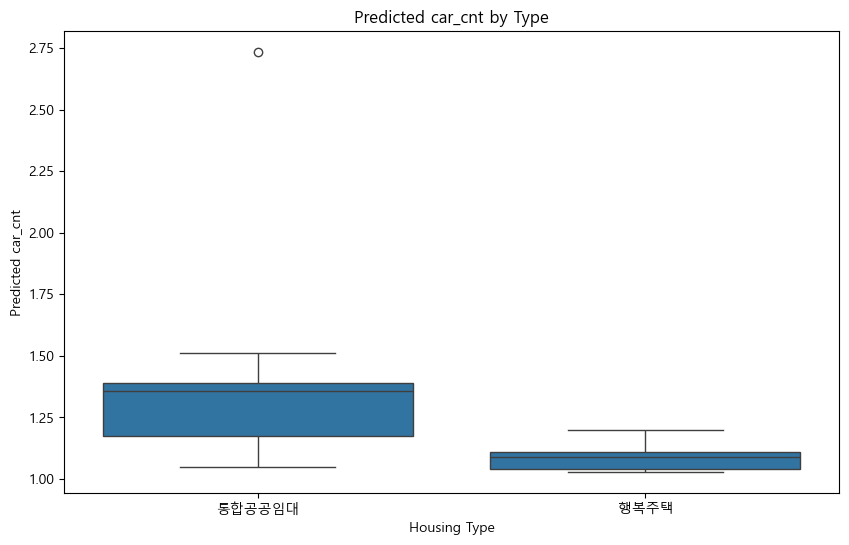

In [370]:
import matplotlib.pyplot as plt
import seaborn as sns

# Type별 Predicted_car_cnt 분포 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(data=property_new_df, x='type', y='Predicted_car_cnt')
plt.title("Predicted car_cnt by Type")
plt.xlabel("Housing Type")
plt.ylabel("Predicted car_cnt")
plt.show()

In [368]:
final_property_new_df = property_new_df[['blockname', 'type', 'noh', 'total_cnt', 'total_tm', 'Predicted_car_cnt', 'geometry']]

In [376]:
final_property_new_df

,blockname,type,noh,total_cnt,total_tm,Predicted_car_cnt,geometry
0,A-1,통합공공임대,823,1663.273114,5587.135208,1.341429,"POLYGON ((127.21965 37.53860, 127.21967 37.538..."
1,A-3,행복주택,394,1161.432585,3898.416378,1.028072,"POLYGON ((127.22110 37.53566, 127.22022 37.534..."
2,A-4,통합공공임대,808,1645.726242,5528.089095,1.511762,"POLYGON ((127.22546 37.53456, 127.22504 37.533..."
3,A-6,행복주택,769,1600.104376,5374.569201,1.200093,"POLYGON ((127.22445 37.53154, 127.22442 37.531..."
4,A-7,통합공공임대,1605,2578.050023,8665.405895,2.733058,"POLYGON ((127.20894 37.52430, 127.20896 37.524..."
5,A-9,통합공공임대,525,1314.675264,4414.085764,1.057679,"POLYGON ((127.19825 37.52470, 127.19825 37.523..."
6,A-10,통합공공임대,491,1274.902355,4280.247908,1.050561,"POLYGON ((127.20050 37.52197, 127.20063 37.521..."
7,A-11,행복주택,715,1536.935638,5162.003195,1.110883,"POLYGON ((127.19541 37.51630, 127.19538 37.516..."
8,A-12,통합공공임대,807,1644.556451,5524.152687,1.359198,"POLYGON ((127.19309 37.51642, 127.19307 37.516..."
9,A-13,행복주택,589,1389.541916,4666.015846,1.088713,"POLYGON ((127.19238 37.51433, 127.19233 37.514..."


In [ ]:
# 맵 객체 생성 및 데이터 로드
final_map = KeplerGl(height=1000, width=1500)
final_map.add_data(data=final_property_new_df, name="차량 적정규모 데이터")
final_map.add_data(data=object_area_df, name="하남시 교산지구 데이터")
# 맵 출력 및 상세설정
final_map

In [162]:
final_property_new_df.to_csv("교산지구 공공주택 공유차량 적정규모.csv", index=False)

In [163]:
final_property_new_df = pd.read_csv("교산지구 공공주택 공유차량 적정규모.csv")
final_property_new_df

,blockname,type,noh,total_cnt,total_tm,Predicted_car_cnt,geometry
0,A-1,통합공공임대,823,1663.273114,5587.135208,1.341430,"POLYGON ((127.2196492650309 37.53860184007405,..."
1,A-3,행복주택,394,1161.432585,3898.416378,1.028072,"POLYGON ((127.2210957628558 37.53565598822367,..."
2,A-4,통합공공임대,808,1645.726242,5528.089095,1.511762,POLYGON ((127.22546141032538 37.53455583396037...
3,A-6,행복주택,769,1600.104376,5374.569201,1.200093,POLYGON ((127.22444957077602 37.53153684654906...
4,A-7,통합공공임대,1605,2578.050023,8665.405895,2.733058,"POLYGON ((127.2089449627878 37.52429743671012,..."
5,A-9,통합공공임대,525,1314.675264,4414.085764,1.057679,POLYGON ((127.19825045039454 37.52470340266480...
6,A-10,통합공공임대,491,1274.902355,4280.247908,1.050561,POLYGON ((127.20049723585068 37.52197480034803...
7,A-11,행복주택,715,1536.935638,5162.003195,1.110883,POLYGON ((127.19541408002533 37.51630069427863...
8,A-12,통합공공임대,807,1644.556451,5524.152687,1.359198,POLYGON ((127.19308795198023 37.51642438960277...
9,A-13,행복주택,589,1389.541916,4666.015846,1.088713,POLYGON ((127.19237630108032 37.51432758884467...


In [164]:
# 맵 객체 생성 및 데이터 로드
final_map = KeplerGl(height=1000, width=1500)
final_map.add_data(data=final_property_new_df, name="차량 적정규모 데이터")
final_map.add_data(data=object_area_df, name="하남시 교산지구 데이터")
# 맵 출력 및 상세설정
final_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'차량 적정규모 데이터': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'colum…